In [1]:
# Import
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv('/Users/antoinebertin/Documents/jedha/project/wineV3_regression/new_dataset.csv')
df.head()

,description,points,price,province,variety
0,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red
1,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris
2,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir
3,This dry and restrained wine offers spice in p...,87,24.0,Alsace,Gewürztraminer
4,Savory dried thyme notes accent sunnier flavor...,87,12.0,Rheinhessen,Gewürztraminer


In [12]:
features_list = ["points", "province", "price"]
X = df.loc[:,features_list]
y = df.loc[:,"variety"]

In [13]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = le.fit_transform(y)

In [15]:
df['variety_encoded'] = y_encoded
y = y_encoded
df.head()

,description,points,price,province,variety,variety_encoded
0,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,36
1,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,33
2,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,34
3,This dry and restrained wine offers spice in p...,87,24.0,Alsace,Gewürztraminer,16
4,Savory dried thyme notes accent sunnier flavor...,87,12.0,Rheinhessen,Gewürztraminer,16


In [12]:
#df.drop(columns='variety', inplace=True)

In [13]:
#df.head()

,description,points,province,variety,cat_price
0,"This is ripe and fruity, a wine that is smooth...",87,Douro,Portuguese Red,0
1,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Pinot Gris,0
2,"Much like the regular bottling from 2012, this...",87,Oregon,Pinot Noir,2
3,This dry and restrained wine offers spice in p...,87,Alsace,Gewürztraminer,1
4,Savory dried thyme notes accent sunnier flavor...,87,Rheinhessen,Gewürztraminer,0


# Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82929, 3), (20733, 3), (82929,), (20733,))

In [18]:
X_train.head()

,points,province,price
83018,86,Colchagua Valley,14.0
49115,87,Champagne,95.0
3952,91,Virginia,20.0
2782,88,Veneto,27.0
52115,86,Galilee,28.0


# model creation

In [19]:
#Numeric features and transformer
numeric_features = [0, 2]  
numeric_transformer = StandardScaler()

#Categorical features and transformers
categorical_features = [1] 

# TODO shuffle index, drop_first..
categorical_transformer = OneHotEncoder()

#ColumnTransformer with mixed types
feature_encoder = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [20]:
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)

# model V3 matrix

In [28]:
# max_depth= prodondeur d'un arbre
# n_estimator= forest size
# min_samples_split= the minimum crowd size it needs to consider before making that decision.
classifier = RandomForestClassifier(n_estimators=100, min_samples_split=80, class_weight="balanced", max_depth=5)

classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=80)

In [29]:
y_train_pred = classifier.predict(X_train)

--- Assessment of performances ---


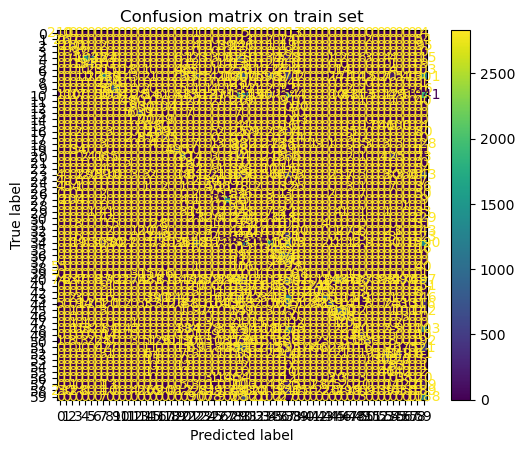

Train score:  0.235575009948269
Test score:  0.23141851155163265


In [30]:
### Assessment of performances ###
print("--- Assessment of performances ---")

# Plot confusion matrix
cm = confusion_matrix(y_train, y_train_pred, labels=classifier.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
cm_display.ax_.set_title("Confusion matrix on train set")
plt.show()
print("Train score: ", classifier.score(X_train, y_train))
print("Test score: ",classifier.score(X_test, y_test))

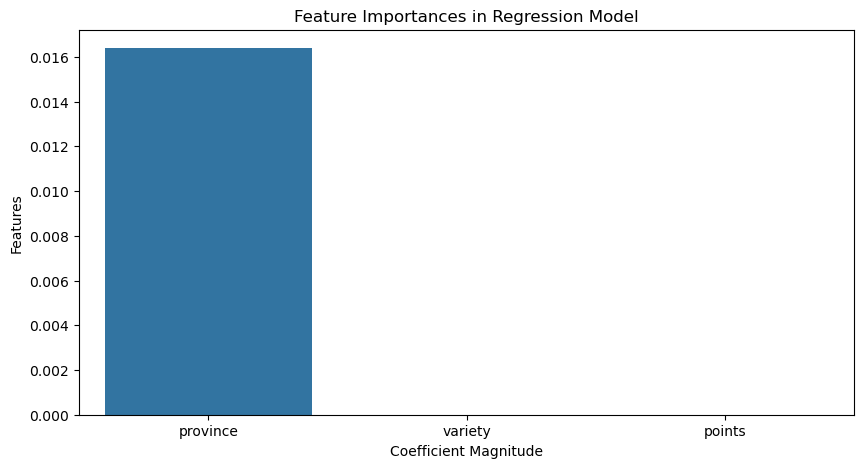

In [31]:
numerical_column_names = X.iloc[:, numeric_features].columns # using the .columns attribute gives us the name of the column 
categorical_column_names = np.concatenate(feature_encoder.transformers_[1][1].categories_)
all_column_names = np.concatenate([categorical_column_names, numerical_column_names])
# Feature importance 
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":classifier.feature_importances_ # CAREFUL HERE. We need to access first index of our list because 
                                            # Data need to be 1 dimensional
                                            # That's what .squeeze()
})
province_coef_mean = np.mean(classifier.feature_importances_[:len(feature_encoder.transformers_[1][1].categories_[0])])
variety_coef_mean = np.mean(classifier.feature_importances_[len(feature_encoder.transformers_[1][1].categories_[0]):-1])


# Coefficient for the numerical feature
points_coef = classifier.feature_importances_[-1]

# Create a simplified DataFrame for feature importance
simplified_feature_importance = pd.DataFrame({
    "feature_names": ['province', 'variety', 'points'],
    "aggregated_coefficients": [province_coef_mean, variety_coef_mean, points_coef]
})
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Sort the DataFrame by coefficients to see the most important features
feature_importance_sorted = simplified_feature_importance.sort_values(by='aggregated_coefficients', ascending=False)

# Create a barplot
sns.barplot(x='feature_names', y='aggregated_coefficients', data=feature_importance_sorted)
plt.title('Feature Importances in Regression Model')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

### tree

In [33]:
# Assuming classifier is a trained RandomForestClassifier
num_trees = classifier.n_estimators
print("Number of trees in the forest:", num_trees)

# Fetch the first tree
single_tree = classifier.estimators_[0]

# Get feature names
feature_names = simplified_feature_importance['feature_names'].to_list()
print("Number of features:", len(feature_names))
print("Features:", feature_names)

Number of trees in the forest: 100
Number of features: 3
Features: ['province', 'variety', 'points']


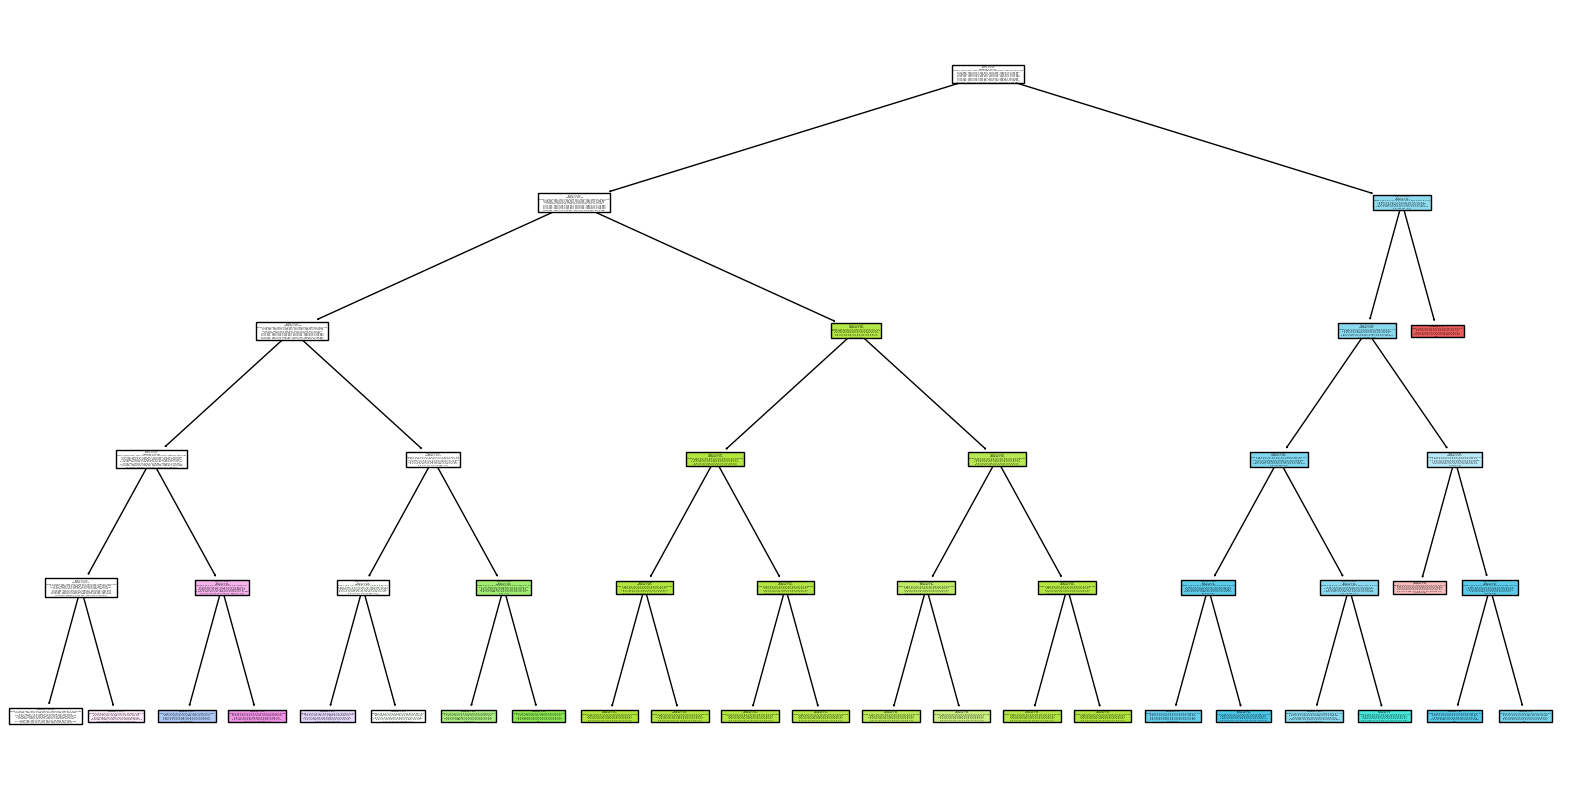

In [34]:
plt.figure(figsize=(20,10))
plot_tree(single_tree, filled=True)
plt.show()

# model test

In [35]:
df.head()

,description,points,price,province,variety,variety_encoded
0,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,36
1,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,33
2,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,34
3,This dry and restrained wine offers spice in p...,87,24.0,Alsace,Gewürztraminer,16
4,Savory dried thyme notes accent sunnier flavor...,87,12.0,Rheinhessen,Gewürztraminer,16


In [36]:
new_prediction = {
    'points': [87],
    'province': ['Douro'],
    'price': [15]
}

df_new_prediction = pd.DataFrame(new_prediction)
new_prediction = feature_encoder.transform(df_new_prediction)

# Make predictions on the new data
the_prediction = classifier.predict(new_prediction)
print(f"The prediction is: {the_prediction}")

The prediction is: [37]
